In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read CSV file into a DataFrame
csv_file_path = "summary_sims_4_objectives.csv"

# prepare folder to save data
figs = []
# remove .csv from the folder name, for example "summary_mokps.csv" to "summary_mokps"
folder_name = csv_file_path.split('.')[0]

                            instance  best  average_score
solver_name front_strategy                               
gurobi      gavanelli             24    14       0.879719
            gavanelli-opt         24     0       0.261964
            saugmecon             23    10       0.836856
ortools-py  gavanelli             20    11       0.939856
            gavanelli-opt         18     4       0.346463
            saugmecon             17    11       0.974214


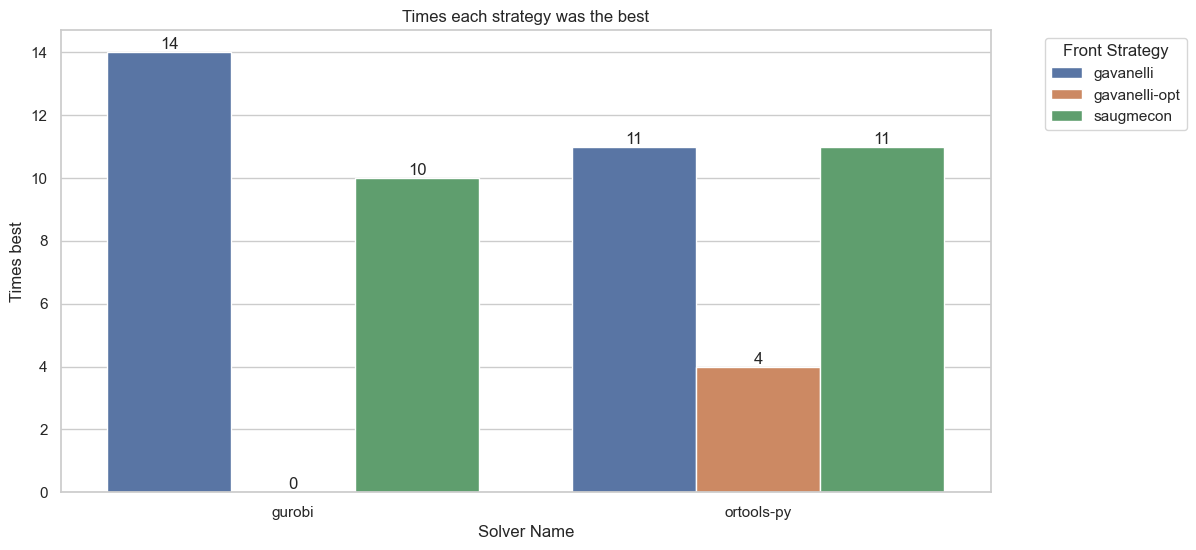

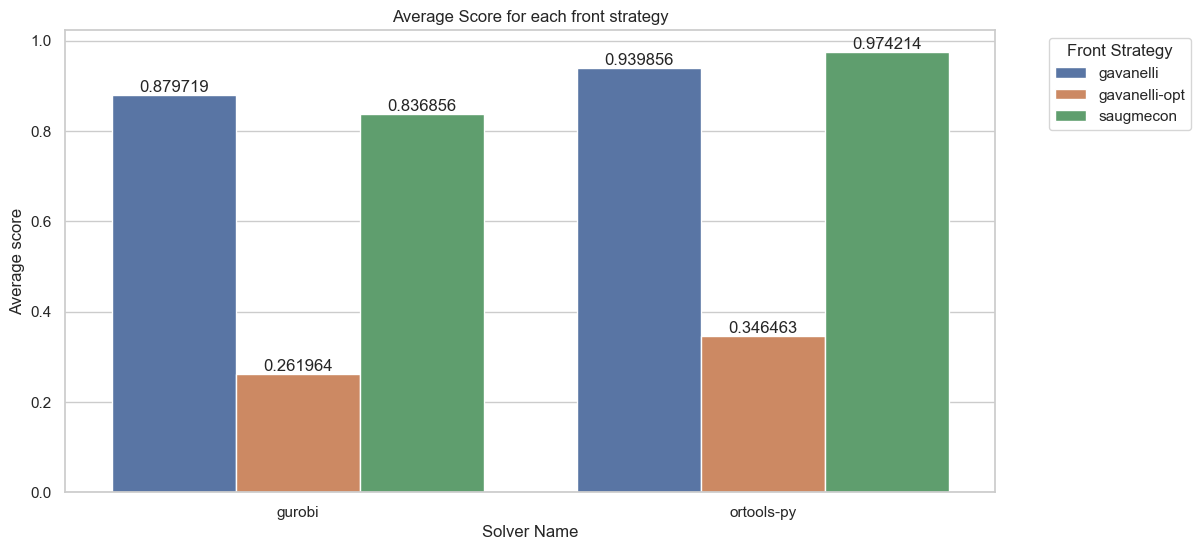

In [6]:
df = pd.read_csv(csv_file_path, delimiter=';')

# Function to calculate score for each front_strategy
def calculate_score(group):
    best_hypervolume = group.loc[group['hypervolume'].idxmax(), 'hypervolume']
    group['score'] = group['hypervolume'] / best_hypervolume
    return group

# Apply the function to calculate scores
df_score_by_front_strategy = df.groupby(['instance', 'solver_name']).apply(calculate_score)
df_score_by_front_strategy =  df_score_by_front_strategy.drop(columns='solver_name')

df_total_front_by_solver = df.groupby(['solver_name', 'front_strategy'])['instance'].count()
df_best_front_by_solver1 = df_score_by_front_strategy[df_score_by_front_strategy['score'] == 1.0].groupby(['solver_name', 'front_strategy']).size().rename('best').to_frame()
df_best_front_by_solver = df_score_by_front_strategy.groupby(['solver_name', 'front_strategy']).size().rename('best').to_frame()
df_best_front_by_solver['best'] = df_best_front_by_solver1['best'].astype(int)
# replace NaN values with 0 and convert to int
df_best_front_by_solver['best'] = df_best_front_by_solver['best'].fillna(0).astype(int)
df_avg_score_by_front_strategy = df_score_by_front_strategy.groupby(['solver_name', 'front_strategy'])['score'].mean().rename('average_score').to_frame()

df_total_best = pd.merge(df_total_front_by_solver, df_best_front_by_solver, left_index=True, right_index=True)
# add a column with the average score for each front strategy
df_total_best_avg_score = pd.merge(df_total_best, df_avg_score_by_front_strategy, left_index=True, right_index=True)
print(df_total_best_avg_score)

# Plotting
fig=plt.figure(figsize=(12, 6))
# Adding text labels on top of bars
ax = sns.barplot(x=df_total_best_avg_score.index.get_level_values('solver_name'), y='best', hue=df_total_best_avg_score.index.get_level_values('front_strategy'), data=df_total_best_avg_score)
for p in ax.containers:
    ax.bar_label(p, label_type='edge')
    
# Adding labels and legend
plt.title('Times each strategy was the best')
plt.xlabel('Solver Name')
plt.ylabel('Times best')
plt.legend(title='Front Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Create the second graph
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=df_total_best_avg_score.index.get_level_values('solver_name'), y='average_score', hue=df_total_best_avg_score.index.get_level_values('front_strategy'), data=df_total_best_avg_score)
for p in ax.containers:
    ax.bar_label(p, label_type='edge')

# Adding labels and legend
plt.title('Average Score for each front strategy')
plt.xlabel('Solver Name')
plt.ylabel('Average score')
plt.legend(title='Front Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
figs.append(fig)

In [7]:
# Plot the time and the number of solutions for each instance
def calculate_time_score(group):
    best_time = group.loc[group['time_solver_sec'].idxmin(), 'time_solver_sec']
    group['time_score'] = group['time_solver_sec'] / best_time
    return group

def calculate_number_of_solutions_score(group):
    best_number_of_solutions = group.loc[group['number_of_solutions'].idxmin(), 'number_of_solutions']
    group['number_of_solutions_score'] = group['number_of_solutions'] / best_number_of_solutions
    return group

def merge_solver_front_strategy_names(group):
    group['solver_front_strategy'] = group['solver_name'] + ' ' + group['front_strategy']
    return group

# Apply the function to calculate scores
df_time_number_solutions = df.groupby(['instance']).apply(calculate_number_of_solutions_score)
df_time = df.groupby(['instance']).apply(calculate_time_score)
df_time_number_solutions['time_score'] = df_time['time_score']

df_solver_front = df.groupby(['instance']).apply(merge_solver_front_strategy_names)
df_time_number_solutions['solver_front_strategy'] = df_solver_front['solver_front_strategy']

df_time_number_solutions = df_time_number_solutions[['instance', 'solver_front_strategy', 'time_score', 'time_solver_sec',
                                                     'number_of_solutions_score', 'number_of_solutions', 'exhaustive']]


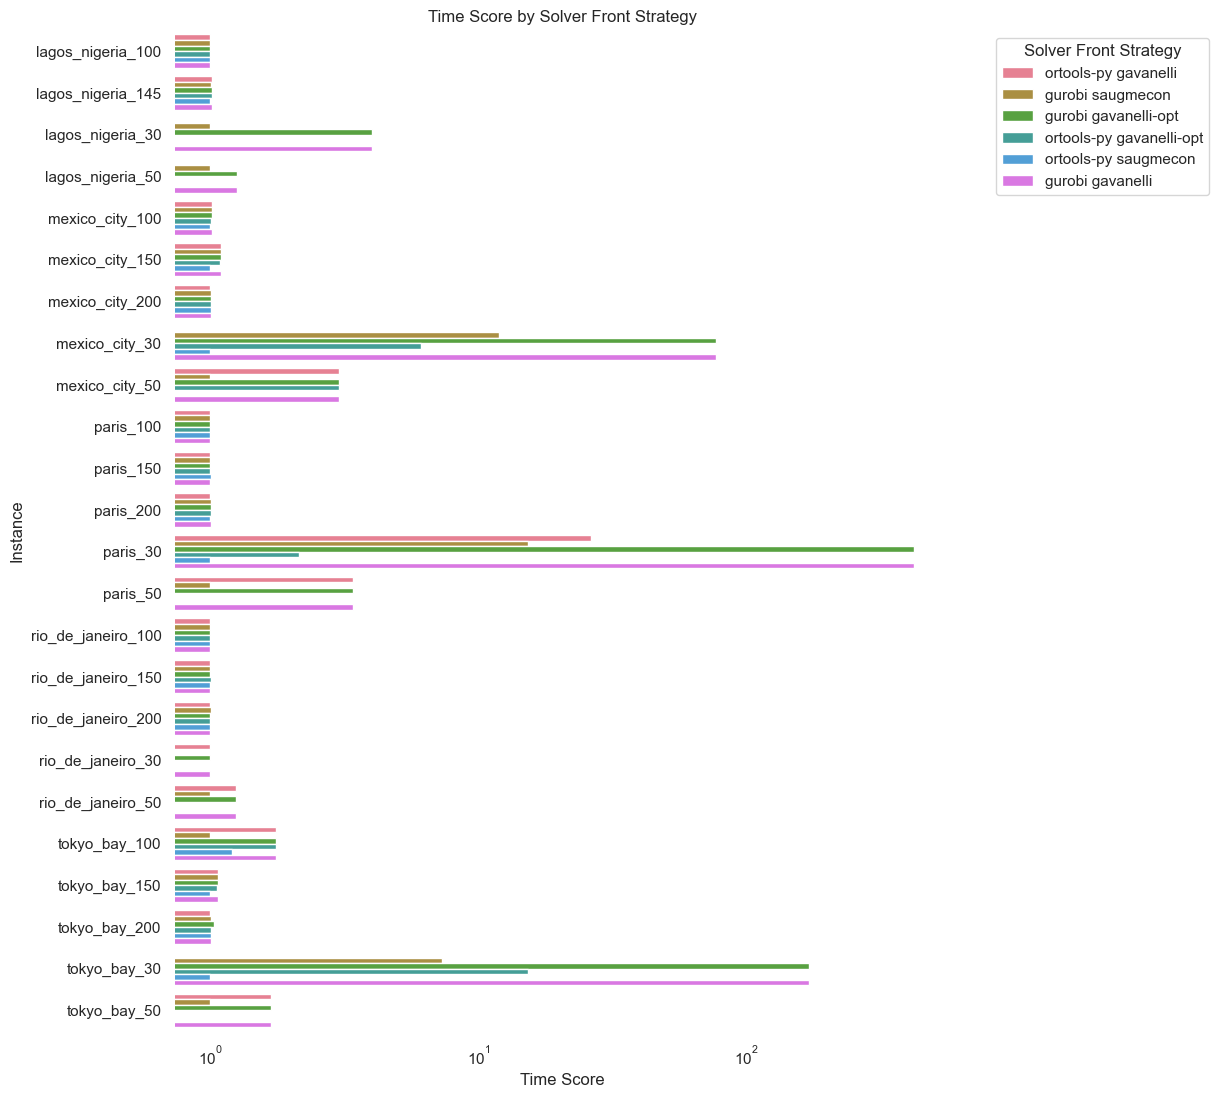

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
fig = plt.figure(figsize=(10, 13))
sns.set_theme(style="whitegrid")

# Define a threshold for applying a logarithmic scale
log_threshold = 10  # Adjust the threshold as needed

# Create a color palette for solver_front_strategy
palette = sns.color_palette("husl", len(df_time_number_solutions['solver_front_strategy'].unique()))

# Plot time scores with a conditional logarithmic x-axis
ax = sns.barplot(x='time_score', y='instance', hue='solver_front_strategy', data=df_time_number_solutions,
            palette=palette, orient='h')

plt.title('Time Score by Solver Front Strategy')
plt.xlabel('Time Score')
plt.ylabel('Instance')
plt.legend(title='Solver Front Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')

# Apply a logarithmic scale only for values greater than the threshold
if df_time_number_solutions['time_score'].max() > log_threshold:
    plt.xscale('log')
    
# Set the background to white and remove the grid lines
sns.despine(left=True, bottom=True)
ax.grid(False)
plt.show()
figs.append(fig)


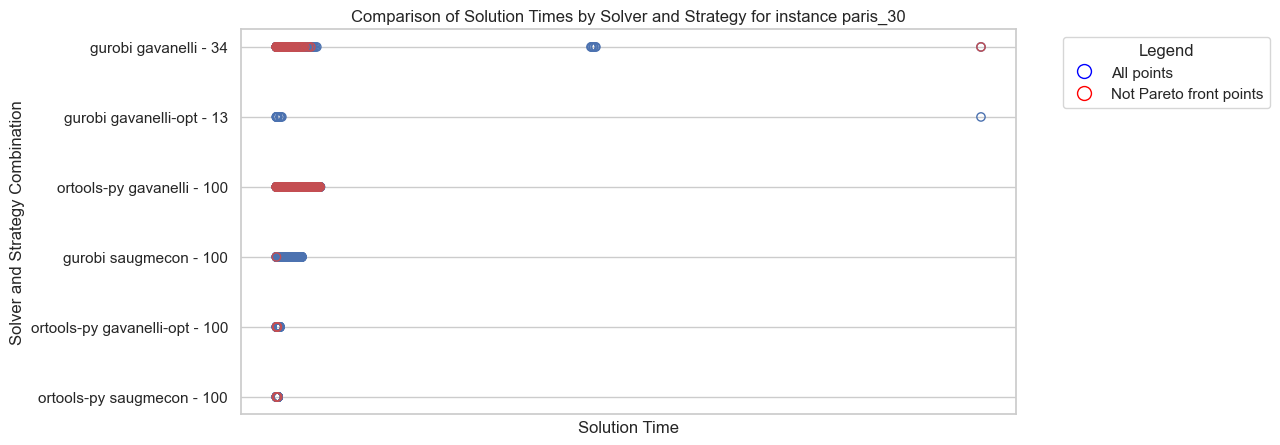

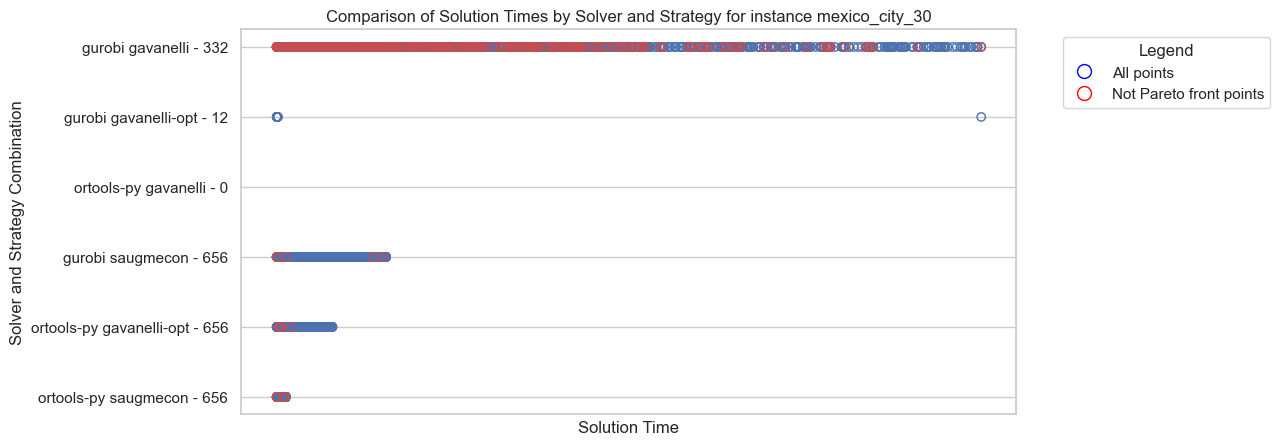

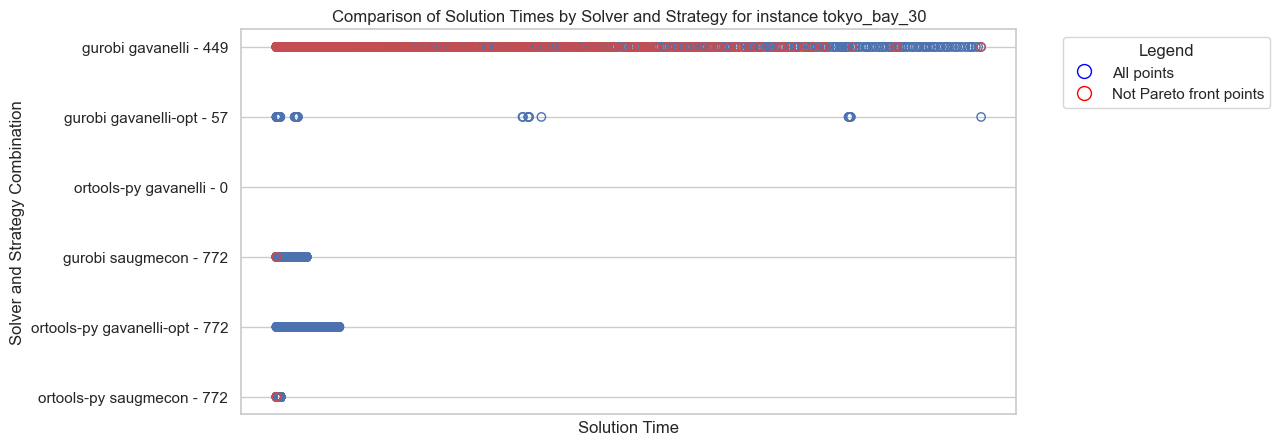

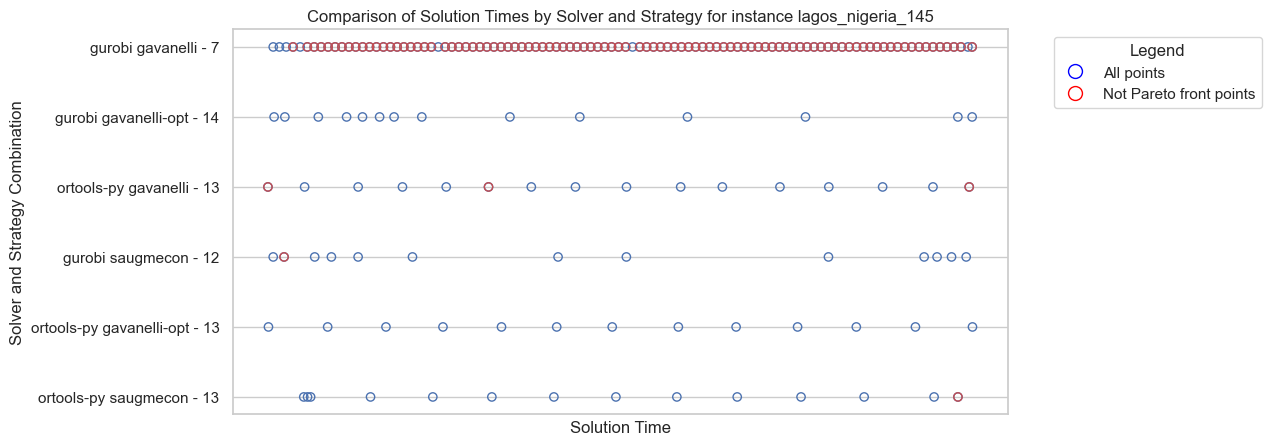

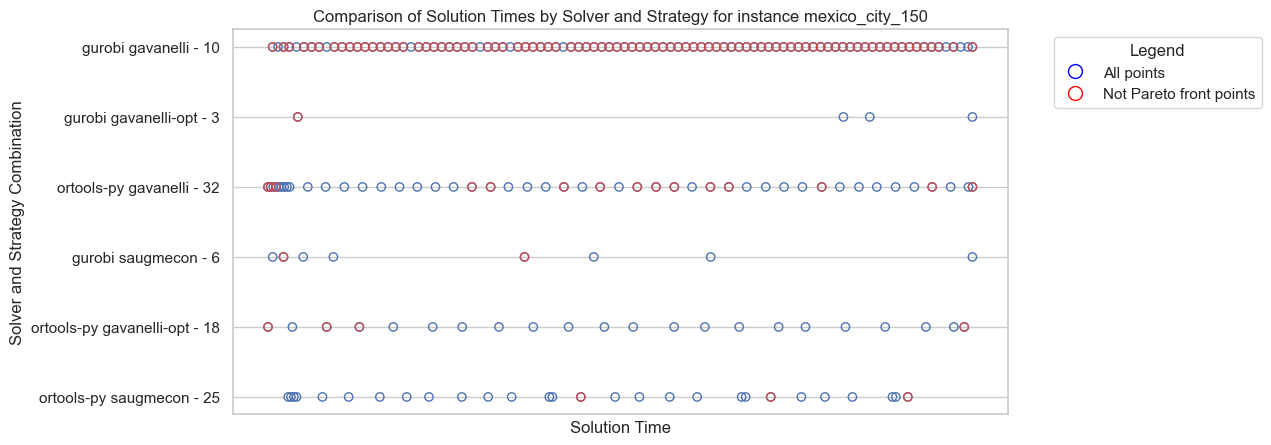

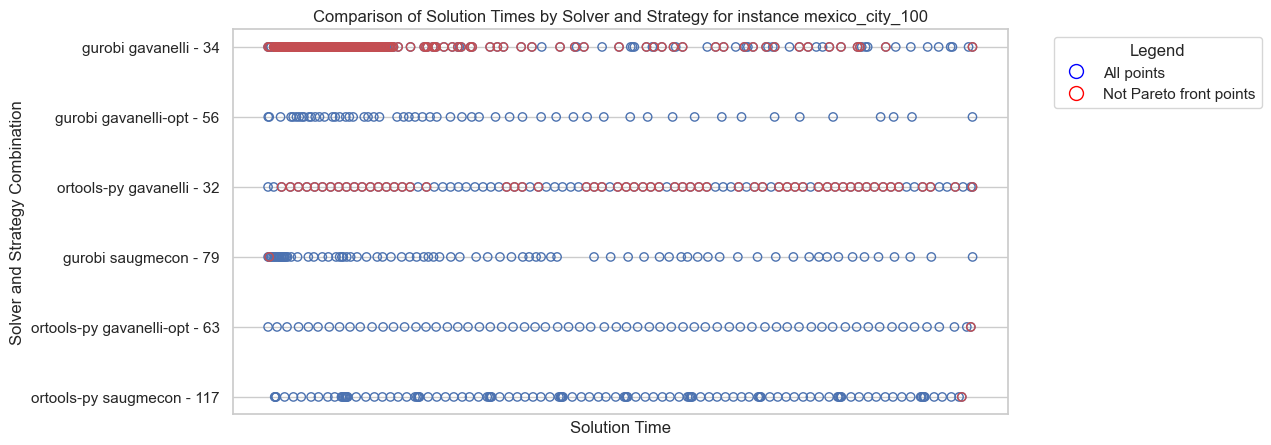

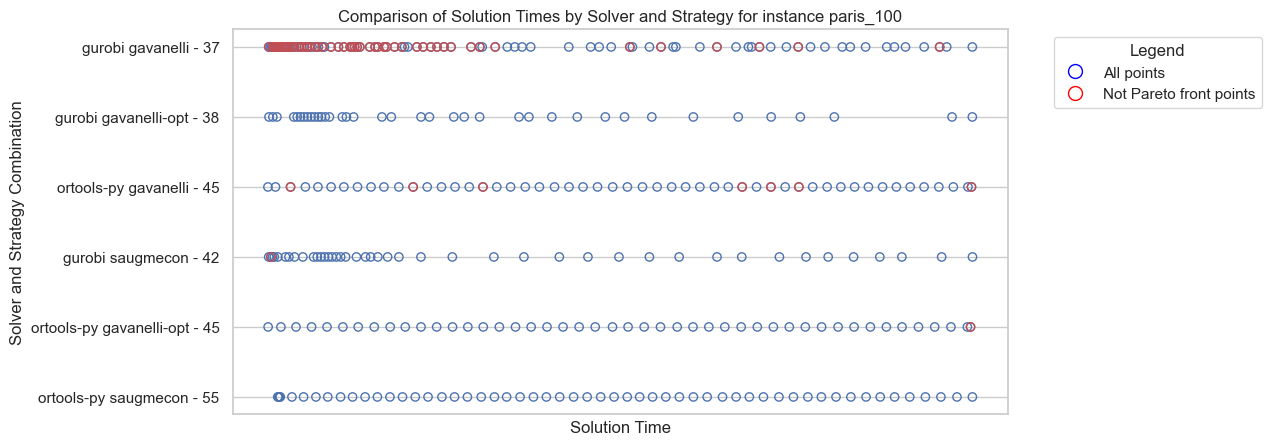

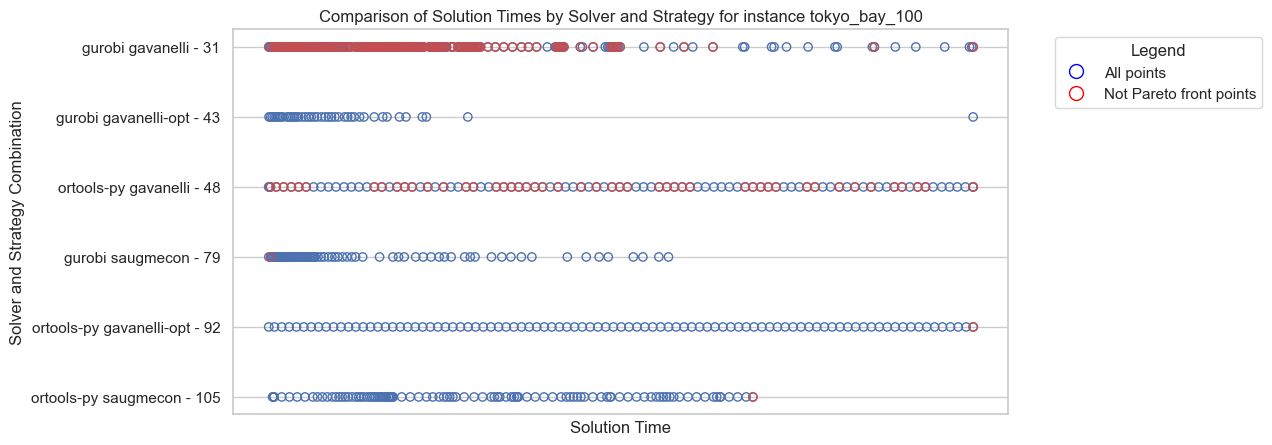

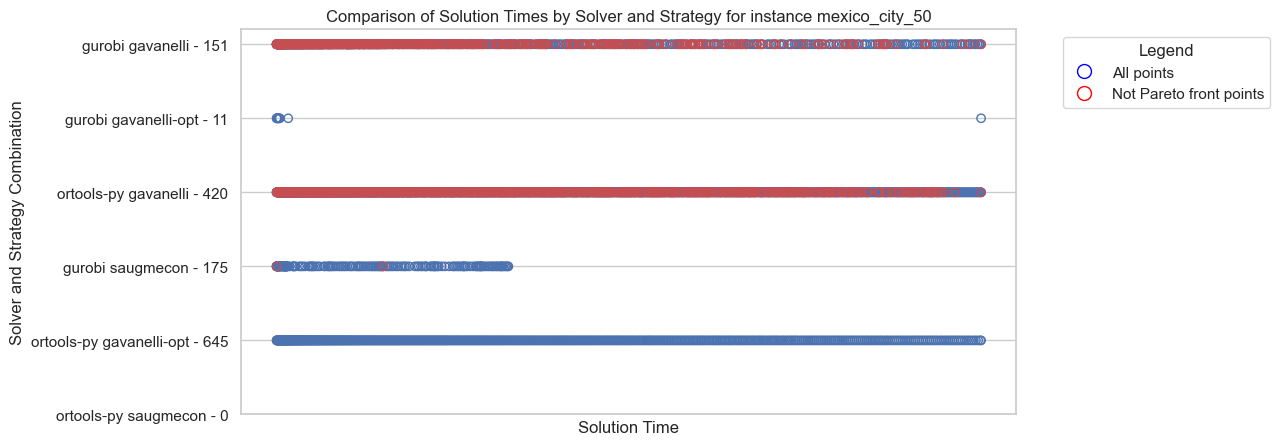

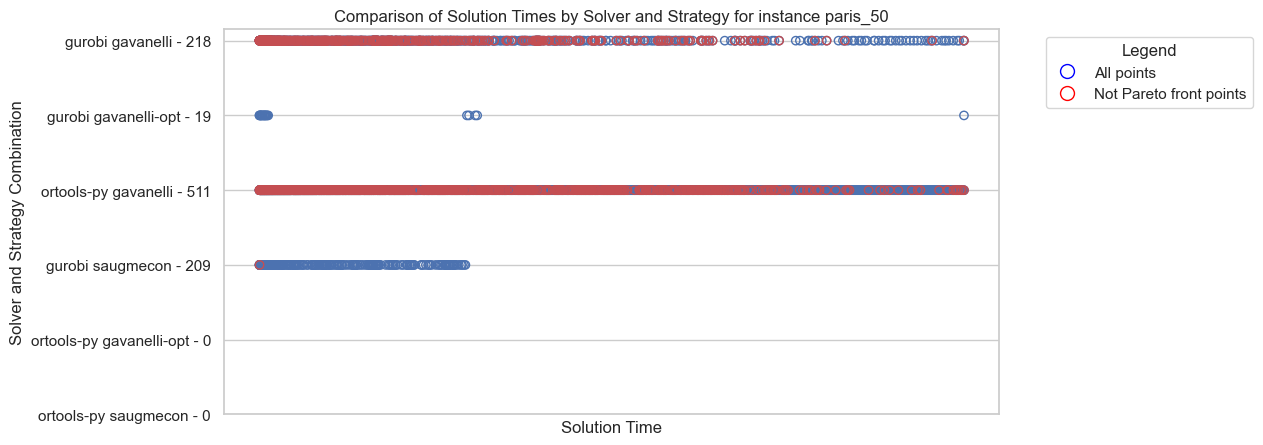

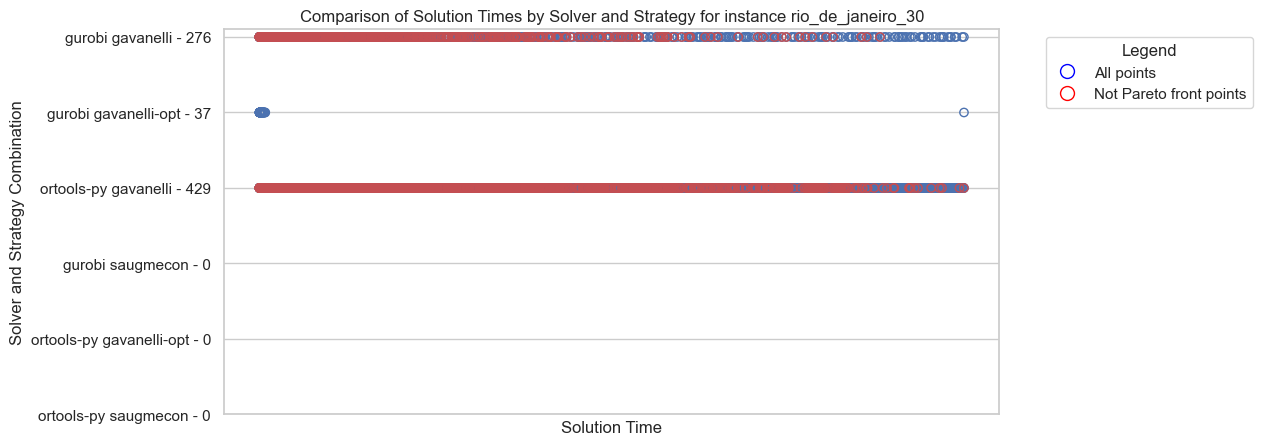

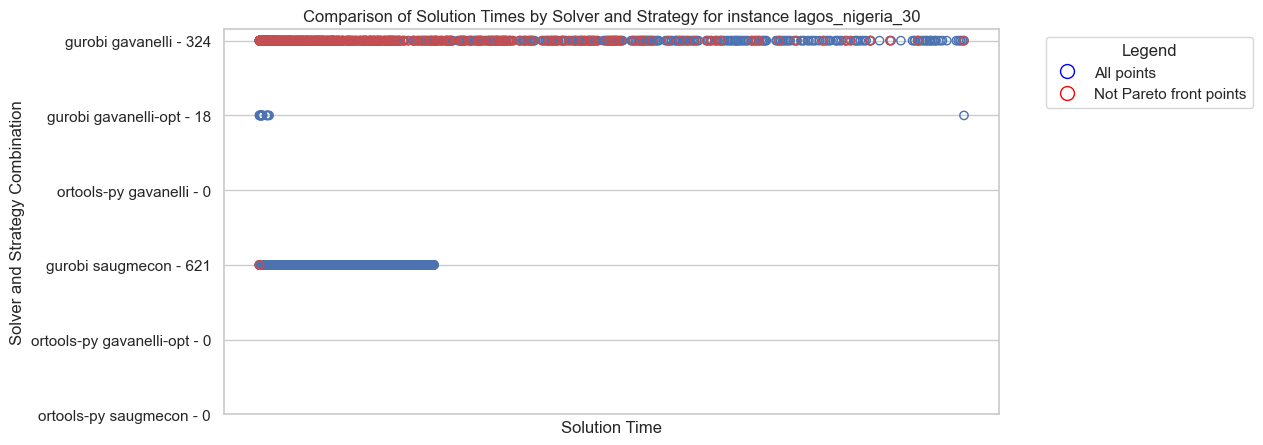

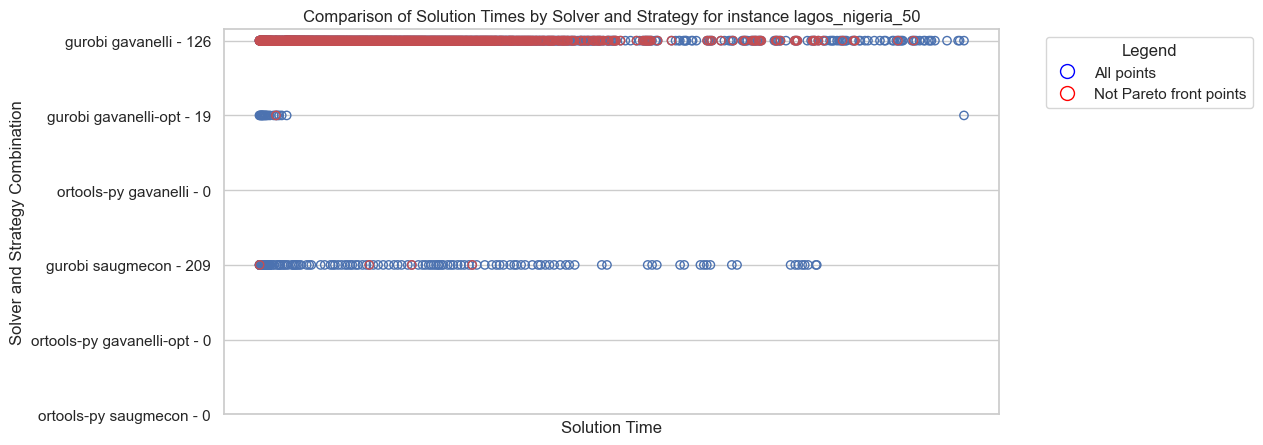

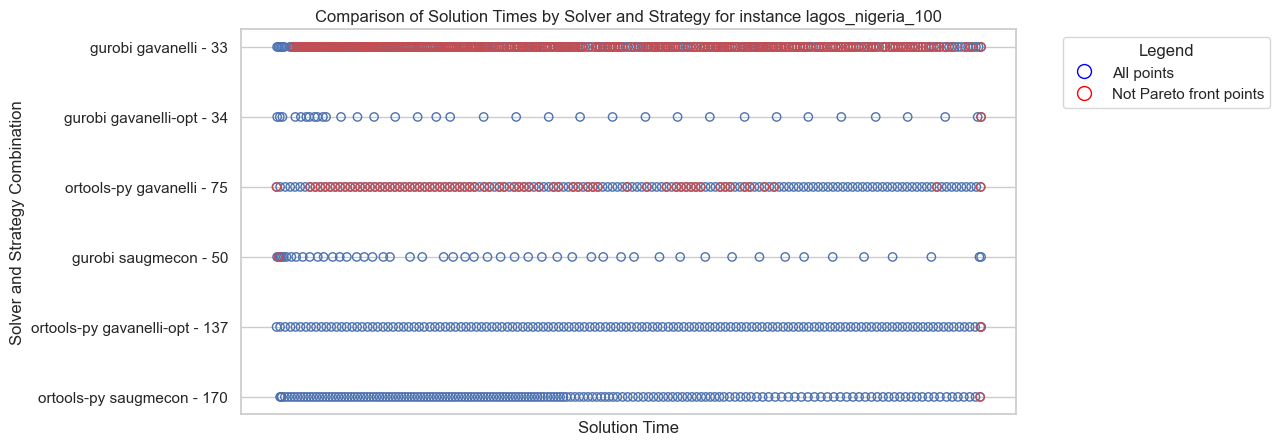

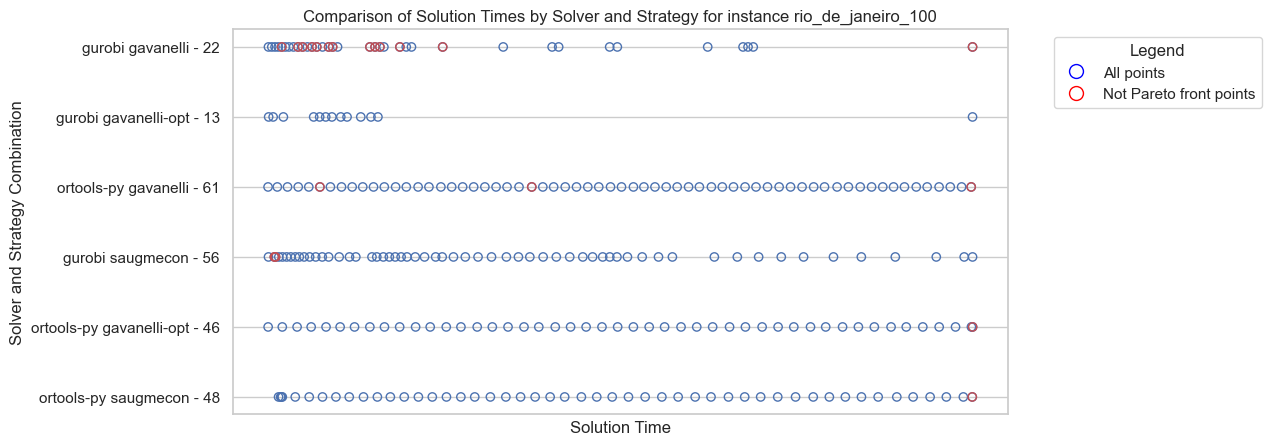

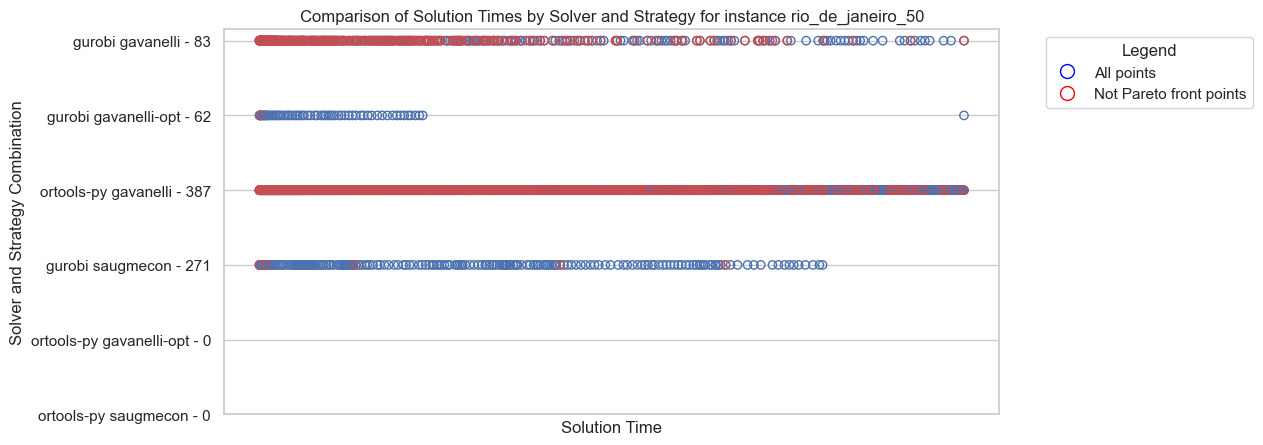

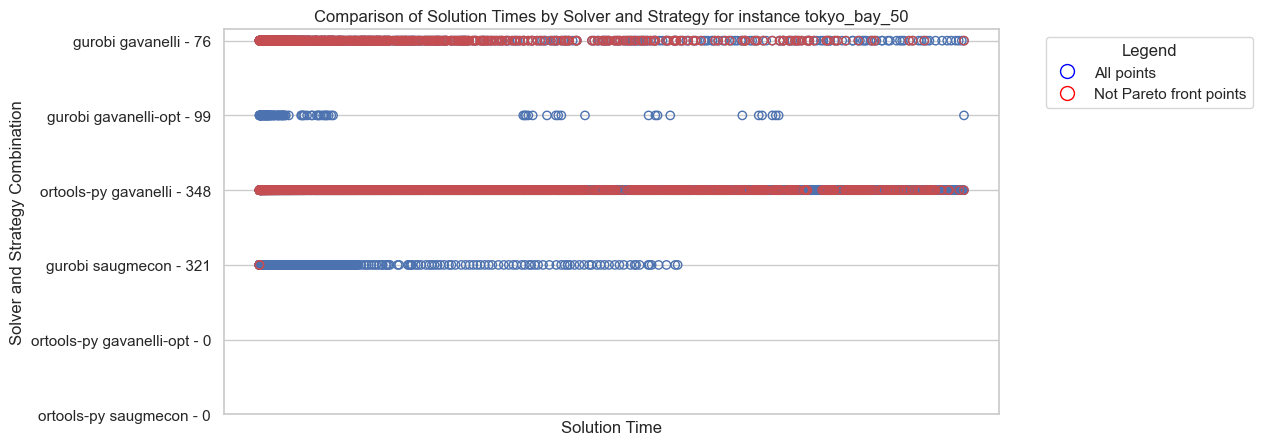

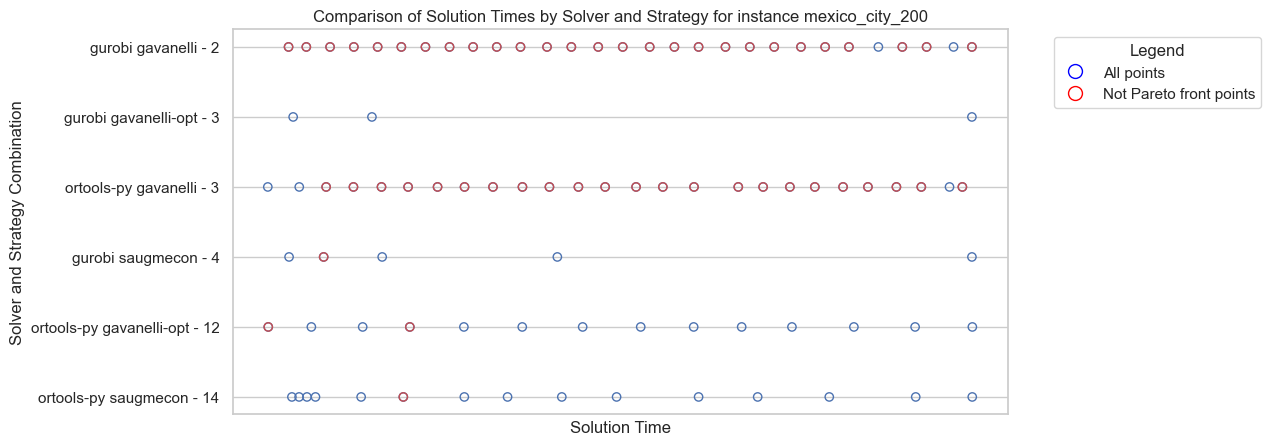

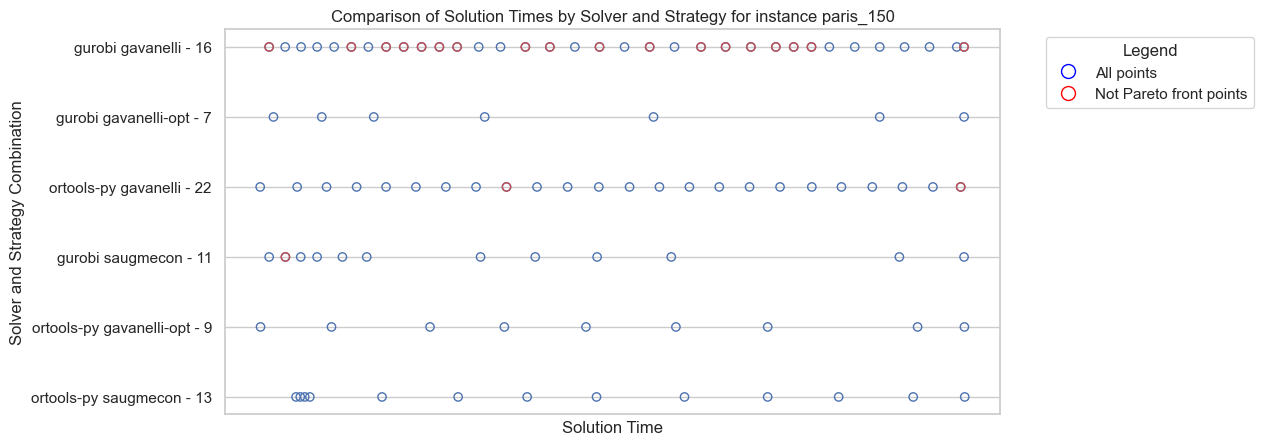

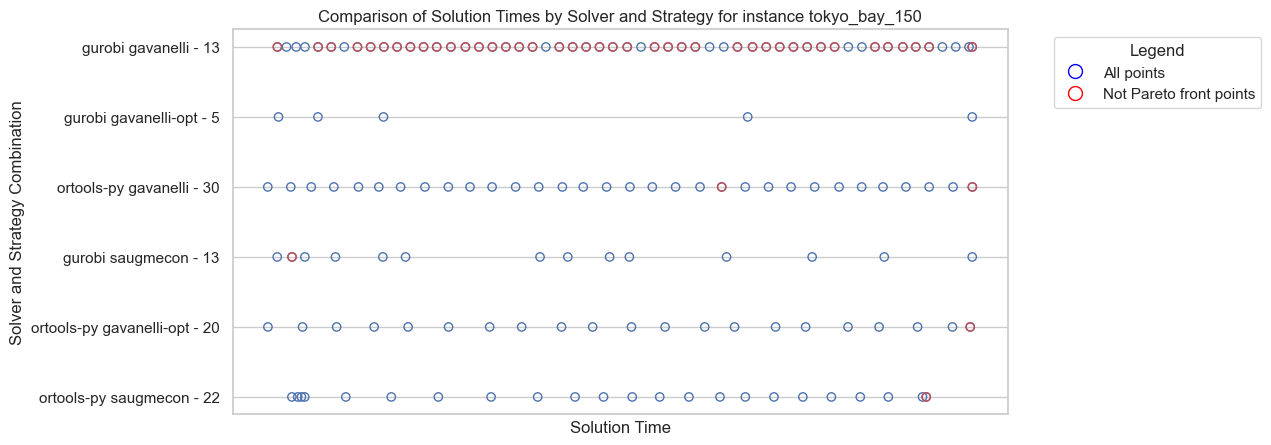

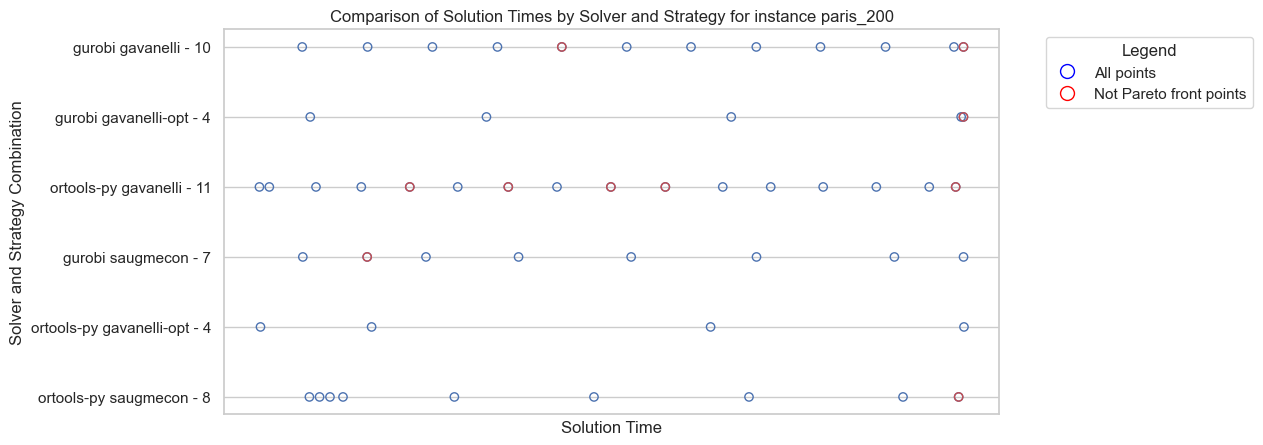

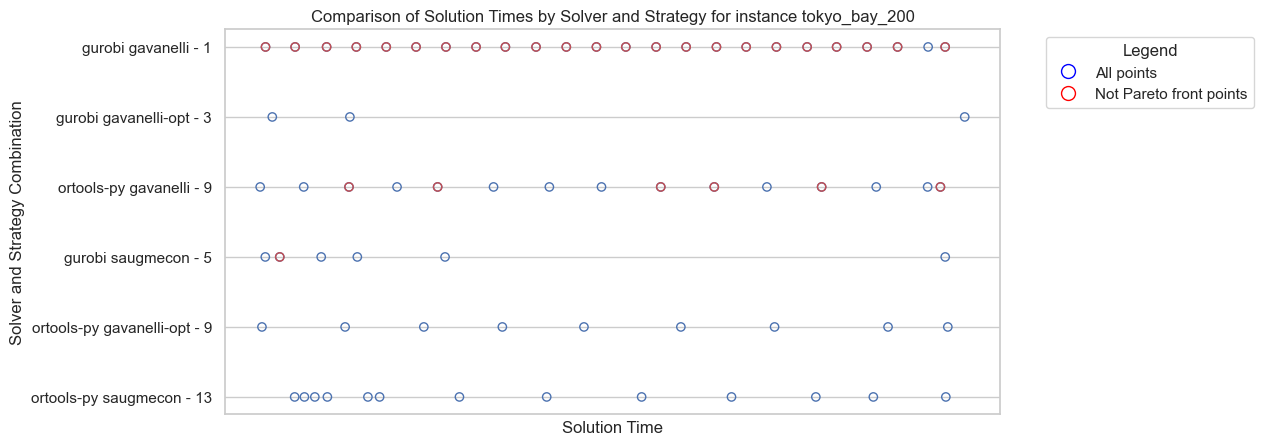

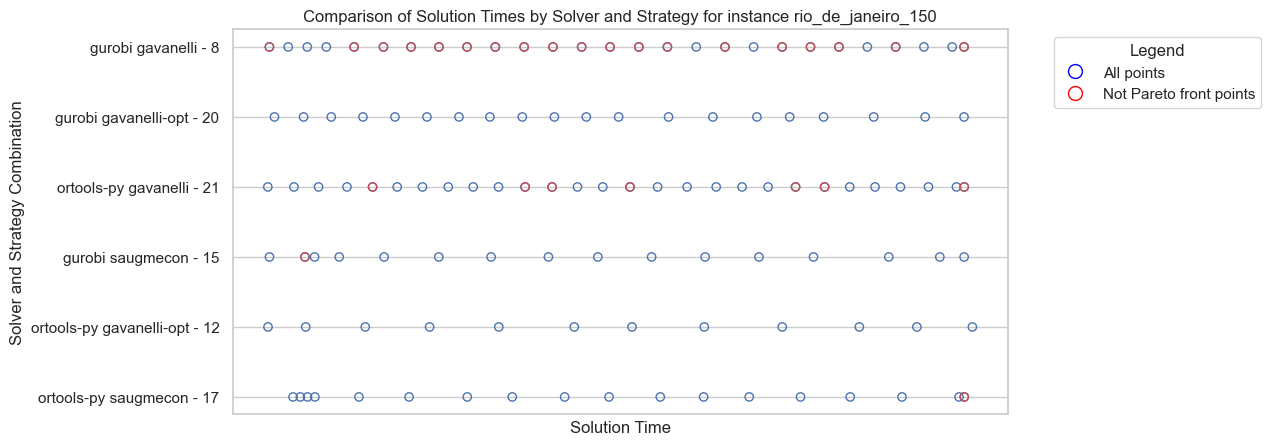

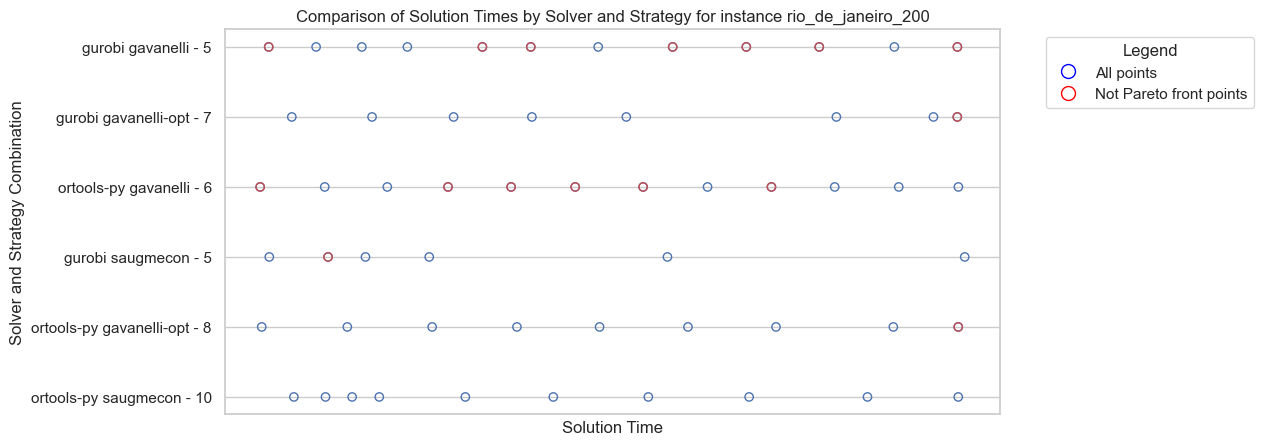

In [9]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and is already defined

# Plot certain instances to check the number of solutions in time and the hypervolume
# instances_list = ['paris_30']
# instances_list = ['mexico_city_30']
instances_list = df['instance'].unique()

# Step 1: Combine solver_name and front_strategy into a new column
df['solver_strategy'] = df['solver_name'] + ' ' + df['front_strategy']

# Map solver_strategy combinations to y-values
unique_combinations = df['solver_strategy'].unique()
combination_to_y = {comb: i for i, comb in enumerate(unique_combinations)}

# Filter the DataFrame for the specified instance
for instances in instances_list:
    filtered_df = df[df['instance'] == instances]
    
    # Set up the plot
    fig = plt.figure(figsize=(10, 5))
    y_ticks_labels = []
    
    # Step 3: Plot data
    for combination in unique_combinations:
        # check if the combination is in the filtered_df
        if combination not in filtered_df['solver_strategy'].values:
            y_ticks_labels.append(f"{combination} - 0")
            continue
        # Directly access the row for the current combination
        row = filtered_df[filtered_df['solver_strategy'] == combination].iloc[0]
        
        # Process the solutions time list and pareto times
        x = [float(time) for time in row['solutions_time_list'].replace('[', '').replace(']', '').split(',')]
        y = [combination_to_y[combination]] * len(x)  # Use the mapped y-value for this combination

        # Update y-tick labels to include the number of Pareto front points
        pareto_front_count = len(row['pareto_front'].split('],['))
        y_ticks_labels.append(f"{combination} - {pareto_front_count}")
        plt.scatter(x, y, facecolors='none', edgecolors='b')  # Plot all points for this combination
         # Step 4: Highlight special points
        pareto_times = row['pareto_solutions_time_list']
        pareto_times = pareto_times.replace('[', '').replace(']', '').split(',')
        pareto_times = [float(time) for time in pareto_times]
        special_x = [time for time in x if time not in pareto_times]
        special_y = [combination_to_y[combination]] * len(special_x)
        plt.scatter(special_x, special_y, facecolors='none', edgecolors='r')  # Filled points for special data
        
    # Step 5: Customize y-axis labels
    plt.yticks(range(len(unique_combinations)), y_ticks_labels)
    
    plt.xlabel('Solution Time')
    plt.ylabel('Solver and Strategy Combination')
    plt.title(f'Comparison of Solution Times by Solver and Strategy for instance {instances}')    
    
    plt.xticks([])
    
    # Show legend with bbox_to_anchor outside the plot area
    all_points = Line2D([], [], color='blue', marker='o', linestyle='None',
                        markersize=10, label='All points', markerfacecolor='none')
    not_pareto_front = Line2D([], [], color='red', marker='o', linestyle='None',
                      markersize=10, label='Not Pareto front points', markerfacecolor='none')

    plt.legend(handles=[all_points, not_pareto_front], title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()
    figs.append(fig)
       


In [10]:
import os
# Save data to folder name
# set this variable to true to save the images and the csv file
save_data = False

if save_data:
    # Ensure the folder exists
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    # save df_total_best_avg_score to a csv file
    df_total_best_avg_score.to_csv(f'{folder_name}/df_total_best_avg_score.csv', sep=';')
    
    # Save each figure
    for i, fig in enumerate(figs):
        image_path = os.path.join(folder_name, f"image_{i+1}.pdf")
        # make sure the fig is displayed correctly and that it is not cut off
        fig.tight_layout()
        fig.savefig(image_path)
        plt.close(fig)
    
    print(f"All images have been saved in the '{folder_name}' folder.")
else:
    print("The data has not been saved. Set the 'save_data' variable to True to save the data.")

The data has not been saved. Set the 'save_data' variable to True to save the data.
